In [1]:
LOGIC = ["Negation", "Double negation", "Intervals/Numbers", "Conjunction", "Disjunction",
          "Conditionals", "Universal", "Existential", "Temporal", "Upward monotone",
          "Downward monotone", "Non-monotone",
        ]
LEXSEM = ["Lexical entailment", "Morphological negation", "Factivity", "Symmetry/Collectivity",
            "Redundancy", "Named entities", "Quantifiers",
         ]
PAS = ["Core args", "Prepositional phrases", "Ellipsis/Implicits", "Anaphora/Coreference",
        "Active/Passive", "Nominalization", "Genitives/Partitives", "Datives", "Relative clauses",
        "Coordination scope", "Intersectivity", "Restrictivity",
      ]
KNOWLEDGE = ["Common sense", "World knowledge"]

In [2]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction

ie_extractor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")

error loading _jsonnet (this is expected on Windows), treating C:\Users\ZEMING~1\AppData\Local\Temp\tmpto81rye3\config.json as plain json


In [78]:
import os
from Udep2Mono.util import *
from Udep2Mono.dependency_parse import dependency_parse
from Udep2Mono.binarization import BinaryDependencyTree, Binarizer
from Udep2Mono.polarization import PolarizationPipeline

from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))
    
binarizer = Binarizer()

[nsubj  [PRP  it]  [conj  [obj  [amod  [JJ  monday friday]  [flat  [NNP  ist]  [CD  10 11pm]]]  [cc  [CC  and]  [VBZ  airs]]]  [obl  [case  [IN  on]  [nmod:tmod  [NNP  june]  [nmod:tmod  [CD  2016]  [CD  27]]]]  [VBD  premiered]]]]


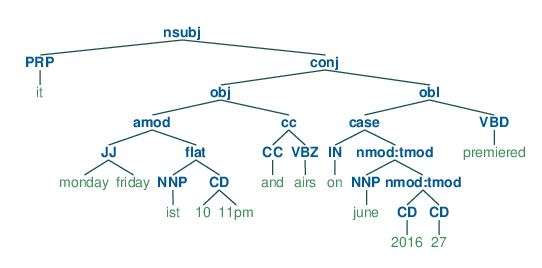

In [79]:
pipeline = PolarizationPipeline()
sentence = "It premiered on 27 June, 2016 and airs Monday-Friday 10-11pm IST"
parsed, replaced = dependency_parse(sentence, pipeline.parser)
binary_dep, relation = pipeline.run_binarization(parsed, replaced, sentence)
sexpression = pipeline.postprocess(binary_dep, replaced).replace("[", "(").replace("]",")")
btreeViz = Tree.fromstring(sexpression)
jupyter_draw_nltk_tree(btreeViz) 

[nsubj  [PRP  he]  [conj  [aux:pass  [VBD  was]  [xcomp  [nmod  [case  [IN  of]  [det  [DT  the]  [amod  [JJ  senior]  [NN  bowl]]]]  [NN  mvp]]  [cc  [CC  and]  [VBN  named]]]]  [advmod  [RB  also]  [obl  [case  [IN  in]  [det  [DT  the]  [amod  [JJ  north south]  [compound  [NN  shrine]  [NN  game]]]]]  [VBD  played]]]]]


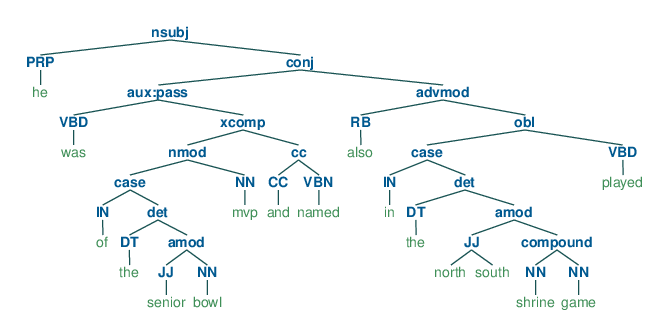

In [81]:
sentence = "He also played in the North-South Shrine Game and was named MVP of the Senior Bowl"
parsed, replaced = dependency_parse(sentence, pipeline.parser)
binary_dep, relation = pipeline.run_binarization(parsed, replaced, sentence)
sexpression = pipeline.postprocess(binary_dep, replaced).replace("[", "(").replace("]",")")
btreeViz = Tree.fromstring(sexpression)
jupyter_draw_nltk_tree(btreeViz) 

In [98]:
phrase_tags = ["nsubj", "xcomp", "obj", "csubj", "acl", "advcl", "acl:relcl", "advmod", "amod", "det"]

def collect_phrases(tree, phrases):
    if tree.val in phrase_tags and not tree.is_root:
        phrases.append(tree.copy())
    if tree.left.is_tree:
        collect_phrases(tree.left, phrases)
    if tree.right.is_tree:
        collect_phrases(tree.right, phrases)

sentence = "John ate some red apples yesterday with Lucy"
parsed, replaced = dependency_parse(sentence, pipeline.parser)
binary_dep, relation = pipeline.run_binarization(parsed, replaced, sentence)
phrases = []
collect_phrases(binary_dep, phrases)
for tree in phrases:
    print([x[0] for x in list(tree.sorted_leaves().popkeys())])

['ate', 'some', 'red', 'apples', 'yesterday', 'with', 'lucy']
['ate', 'some', 'red', 'apples']
['some', 'red', 'apples']
['red', 'apples']


In [99]:
sentence = "A person with a smile on his face"
parsed, replaced = dependency_parse(sentence, pipeline.parser)
binary_dep, relation = pipeline.run_binarization(parsed, replaced, sentence)
phrases = []
collect_phrases(binary_dep, phrases)
for tree in phrases:
    print([x[0] for x in list(tree.sorted_leaves().popkeys())])

['a', 'smile']
['a', 'person']


In [7]:
from pattern.en import conjugate, lemma, lexeme, PAST, PRESENT, PARTICIPLE

def pass2act(sentence, postag):
    ie_pred = ie_extractor.predict(sentence)['verbs']
    
    def fix_info(desc):
        out = desc.replace("ARG0: ", "")
        out = out.replace("ARG1: ", "")
        out = out.replace("V: ", "")
        out = out.replace("[", "")
        out = out.replace("]", ",")
        out = out.split(",")
        return out
    
    def get_aux(noun, verb):
        aux = "is"
        if postag[noun][1] == "NN":
            if postag[verb][1] == "VBD":
                aux = "was"
            elif postag[verb][1] == "VBS":
                aux = "will be"
            else:
                aux = "is"
        elif postag[noun][1] == "NNS":
            if postag[verb][1] == "VBD":
                aux = "were"
            elif postag[verb][1] == "VBS":
                aux = "will be"
            else:
                aux = "are"
        return aux + " "
        
    
    for verb in ie_pred:
        predicate = fix_info(verb['description'])
        print(predicate)
        passive = [0,0,0]
        passive[0] = predicate[2].strip()
        passive[2] = "by " + predicate[0].strip()
        passive_verb = conjugate(predicate[1].strip(), (PAST,PARTICIPLE), 1)
        parsed, _ = dependency_parse(passive[0], "stanza")
        tree, _, words = parsed 
        noun = ""
        for node in tree:
            if node[0] == "root":
                noun = words[node[1]][0]
                print(noun)
        aux = get_aux(noun, predicate[1].strip())
        passive[1] = aux + passive_verb
        print(passive)

In [8]:
parsed, replaced = dependency_parse("John took some apples", "stanza")
tree, postag, words = parsed
pass2act("John took some apples", postag)

['John', ' took', ' some apples', '']
apples
['some apples', 'were taken', 'by John']


In [9]:
parsed, replaced = dependency_parse("I took my exam yesterday", "stanza")
tree, postag, words = parsed
pass2act("I took my exam yesterday", postag)

['I', ' took', ' my exam', ' ARGM-TMP: yesterday', '']
exam
['my exam', 'was taken', 'by I']


In [2]:
# is smiling => with a smile
import fasttext
from sapphire import Sapphire

In [3]:
model = fasttext.FastText.load_model("sapphire/model/wiki-news-300d.bin")

In [115]:
aligner = Sapphire(model)
aligner.set_params(lambda_=0.6, delta=0.6, alpha=0.01, hungarian=True)

In [118]:
s1 = "Three women enjoying a balloon joyride".split(" ")
s2 = "Three women are on a balloon ride.".split(" ")
wa, pa = aligner(s1, s2)

print(s1)
print(pa)

for pair in pa:
    print(pair)
    print(s1[pair[0]-1:pair[1]])
    print(s2[pair[2]-1:pair[3]])

['Three', 'women', 'enjoying', 'a', 'balloon', 'joyride']
[(1, 2, 1, 2), (4, 5, 5, 6)]
(1, 2, 1, 2)
['Three', 'women']
['Three', 'women']
(4, 5, 5, 6)
['a', 'balloon']
['a', 'balloon']
